In [1]:
import os
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pickle

In [2]:
def fetch_model(fpath):
    infile = open(fpath, 'rb')
    res_dict = pickle.load(infile)
    infile.close()
    return res_dict

In [3]:
def coef2matrix(coef, n_roi=192, top_coef_ratio=0.03):
    coef = coef.reshape(-1)
    n_top_coef = int(coef.shape[0] * top_coef_ratio)
    print(n_top_coef)
    idx_sorted = (-abs(coef)).argsort()
    coef_ = np.zeros(coef.shape)
    coef_[idx_sorted[:n_top_coef]] = coef[idx_sorted[:n_top_coef]]
    idx = np.triu_indices(n_roi, k=1)
    coef_matrix = np.zeros((n_roi, n_roi))
    coef_matrix[idx] = coef_[:]
    coef_matrix = coef_matrix.T
    coef_matrix[idx] = coef_[:]
    
    return coef_matrix

In [4]:
import seaborn as sns

def plot_tri_coef(coef_matrix, xlabels=False, ylabels=False, fig_name='figure.pdf', cmap='coolwarm'):
    mask = np.zeros_like(coef_matrix)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,12))
    sns.heatmap(data=coef_matrix, mask=mask, xticklabels=xlabels, yticklabels=ylabels, cmap=cmap)
    plt.yticks(fontsize=3)
    plt.xticks(fontsize=3)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [25]:
def cat_coef(res_dict, kernel_rev=False):
    coef_ = []
    for i in range(len(res_dict['clf'])):
        pca = res_dict['embed'][i]
        clf = res_dict['clf'][i]
        clf_coef = clf.coef_
        if kernel_rev:
            clf_coef = np.dot(clf_coef.T, clf._X)
        coef_.append(pca.inverse_transform(clf_coef).reshape((1, -1)))
        
    return np.concatenate(coef_, axis=0)

### AICHA Model

In [15]:
# redige coefficients
basedir = 'D:/ShareFolder/AICHA_VolFC/Result'
fname = 'intra_half_brain_Ridge_REST1_144.pickle'
# fname = 'intra_half_brain_Ridge_REST1_144.pickle'
res_dict = fetch_model(os.path.join(basedir, fname))
ridge_coef = cat_coef(res_dict)

In [36]:
# regularised clf coefficients
basedir = 'D:/ShareFolder/AICHA_VolFC/Result'
# fname = 'intra_half_brain_SIDeRLS_REST1_144.pickle'
# fname = 'intra_half_brain_Ridge_REST1_144.pickle'
fname =  'intra_half_brain_SVC_REST1_LR_144.pickle'
res_dict = fetch_model(os.path.join(basedir, fname))
sider_coef = cat_coef(res_dict)

In [37]:
from scipy.stats import pearsonr

corrs = []
for i in range(10):
    coef_i = ridge_coef[i, :]
    for j in range(10):
        coef_j = sider_coef[j, :]
        corr, _ = pearsonr(coef_i.reshape(-1), coef_j.reshape(-1))
        corrs.append(corr)
        print(corr)

0.8647510166402261
0.8651446054186045
0.8437044303181862
0.8374912044418097
0.8710054184975751
0.850399131778997
0.8622856164678376
0.8660035242510282
0.8419745663036243
0.8556501173289457
0.8628764471305692
0.8588365821712928
0.8464237171608358
0.83196671033154
0.8597168998716876
0.8406938755746942
0.8537188345914943
0.8592208306749681
0.8381443708929035
0.8612533031477312
0.8664925855943092
0.8711305600746732
0.8505240098841522
0.8881626194117508
0.8721092495956306
0.8663602407749613
0.8602557888421685
0.8676476191780229
0.8572080047787044
0.8799424204074004
0.8715835073012056
0.870051159629031
0.8655442206505191
0.897259936256267
0.8777526905786245
0.8692775583566157
0.8710748851335617
0.8677015990275834
0.8585039227646498
0.8873391246413938
0.8594732331637519
0.8679175536288505
0.860179061941527
0.8899474855599432
0.8706351180672776
0.8708287491130748
0.8687769147025071
0.8674462539179815
0.8672162305459468
0.8805353923596881
0.8701565101283515
0.8766313605596346
0.8583776631731129

In [38]:
np.mean(corrs)

0.8674589268048192

In [39]:
np.std(corrs)

0.011832011856053502

In [29]:
ridge_coef.shape

(10, 18336)

In [28]:
print(corr)

0.8352216802842669


In [7]:
import pandas as pd

roi_list_fpath = 'D:\ShareFolder\AICHA_VolFC\AtlasInfo\AICHA_ROI_MNI_V1.txt'

rois = pd.read_table(roi_list_fpath, header=None)
roi_list = list(rois.loc[0::2, 0])
sub_roi_names = [sub_roi.replace('-L', '') for sub_roi in roi_list]
roi_nams = [name.split('-')[0] for name in sub_roi_names]

In [ ]:
plot_tri_coef()

In [8]:
coef_all.shape

(10, 18336)

### BNA Model

In [3]:
basedir = 'D:/ShareFolder/BNA/Result'
fname = 'intra_half_brain_SVC_REST1_144.pickle'
res_dict = fetch_model(os.path.join(basedir, fname))

In [22]:
pca = res_dict['embed'][0]
clf = res_dict['clf'][0]
coef_ = pca.inverse_transform(clf.coef_)
coef_matrix = coef2matrix(coef_, n_roi=123)

225


In [23]:
import pandas as pd
import io_

roi_list_fpath = 'D:\ShareFolder\BNA\subregion_func_network.xlsx'

rois = io_.read_table(roi_list_fpath, sheet_name='Brainnetome')['region']
roi_list = list(rois.loc[0::2])
roi_names = [sub_roi.replace('_L', '') for sub_roi in roi_list]
# roi_nams = [name.split('-')[0] for name in sub_roi_names]

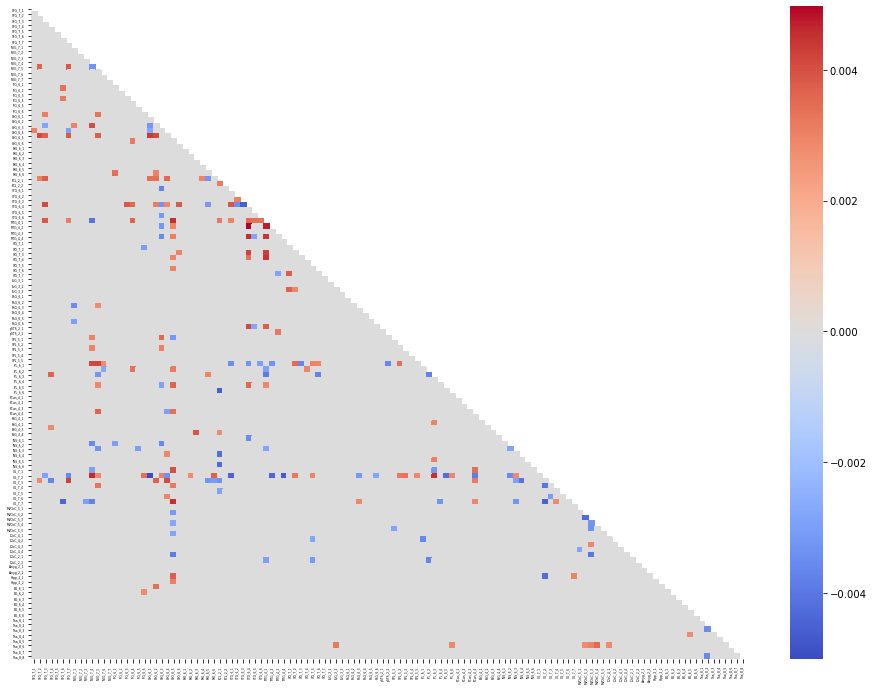

In [24]:
plot_tri_coef(coef_matrix, cmap='coolwarm', xlabels=roi_names, ylabels=roi_names, fig_name='BNA_SVC.pdf')

### Correlation analysis

In [19]:
res_dict

{'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9951690821256038, 1.0, 1.0, 1.0],
 'auc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'embed': [PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144)],
 'clf': [SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear')],
 'params': [{'PCA': {'n_components': 500},
   'clf': {'C': 1, 'kernel': 'linear'}},
  {'PCA': {'n_components': 500}, 'clf': {'C

In [20]:
pca1 = res_dict['embed'][3]
clf1 = res_dict['clf'][3]
coef1_ = pca1.inverse_transform(clf1.coef_)

In [21]:
from scipy.stats import pearsonr

corr, _ = pearsonr(coef_.reshape(-1), coef1_.reshape(-1))

In [22]:
corr

0.8571242875472798

In [35]:
coef_random0 = np.random.random(coef_.shape)
coef_random1 = np.random.random(coef_.shape)

corr, _ = pearsonr(coef_random0.reshape(-1), coef_random1.reshape(-1))

In [5]:
coef_matrix = coef2matrix(coef_)

916


In [5]:
def plot_coef(coef_matrix, xlabels=None, ylabels=None, cmap='gist_heat', fig_name='figure.pdf'):
    if xlabels is not None:
        plt.xticks(ticks=np.arange(len(xlabels)),labels=xlabels, rotation=90)
    if ylabels is not None:
        plt.yticks(ticks=np.arange(len(ylabels)),labels=ylabels)    
    plt.imshow(coef_matrix, cmap='cool',interpolation="nearest")
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [11]:
import seaborn as sns

def plot_coef(coef_matrix, xlabels=False, ylabels=False, fig_name='figure.pdf'):
    
    sns.heatmap(data=coef_matrix, xticklabels=xlabels, yticklabels=ylabels)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [56]:
import chart_studio.plotly as ply
import plotly.graph_objs as go

def make_layout(title, plot_size):
    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

    return go.Layout(title=title,
                  xaxis=dict(axis),
                  yaxis=dict(axis),
                  showlegend=False,
                  width=plot_size,
                  height=plot_size,
                  margin=dict(t=25, b=25, l=25, r=25),
                  hovermode='closest',
                  shapes=[]# to this list one appends below the dicts defining the ribbon,
                           #respectively the ideogram shapes
                 )

In [ ]:
link = {'source': [], 'target': [], 'value': []}

for i in range(192):
    for j in range
    link['source'].append

In [14]:
coef_df = pd.DataFrame(data=coef_matrix, columns=roi_names)
coef_df.to_csv('Coef_matrix_sample1.csv', index=False)

In [ ]:
layout=make_layout('Chord diagram', 400)

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score
import io_

pca = res_dict['embed'][0]
clf = res_dict['clf'][0]

data_dir = 'D:/ShareFolder/AICHA_VolFC/Proc'
sessions = ['REST1', 'REST2']
runs = ['RL', 'LR']
connection_type = 'intra'
atlas = 'AICHA'
for session in sessions:
    for run_ in runs:
        data = io_.load_half_brain(data_dir, atlas, session, run_, connection_type)
        x_left = data['Left']
        y_pred = clf.predict(pca.transform(x_left))
        print(accuracy_score(np.ones(y_pred.shape), y_pred))
        
        x_right = data['Right']
        y_pred = clf.predict(pca.transform(x_right))
        print(accuracy_score(-1 * np.ones(y_pred.shape), y_pred))
        

0.9655831739961759
0.9933078393881453
1.0
1.0
0.9794661190965093
0.9856262833675564
1.0
1.0
